# Standard GAN 구현하기

In [94]:
# 필요한 모듈을 업로드합니다.
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

use_cuda = torch.cuda.is_available()


In [95]:
import torchvision
import torchvision.transforms as transforms
import cv2

## Data load, preprocess

In [96]:
# Image를 Cropping 하는 과정입니다.
# Dataset은 celebA의 일부를 사용하였습니다.
# ImageFolder내에 있는 모든 사진파일을 하나씩 꺼내오는 작업입니다.
transform = transforms.Compose(
    [transforms.CenterCrop((64,64)),
     transforms.ToTensor(),])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

celebA = torchvision.datasets.ImageFolder('/Users/soobin/Deepest/GANs', transform=transform)

In [97]:
dataloader = torch.utils.data.DataLoader(celebA, batch_size=16, shuffle=True, num_workers=2)

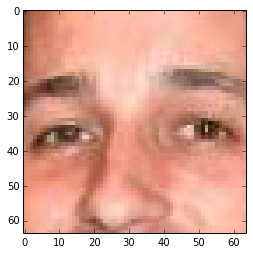

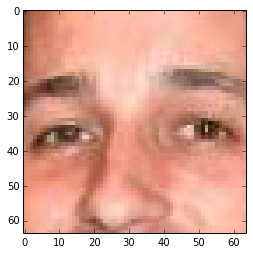

In [98]:
data,_ = iter(dataloader).next()

to_pil = torchvision.transforms.ToPILImage()
to_pil(data[0])

import matplotlib
from matplotlib import pyplot as plt
from IPython import display
# from pylab import plt
%matplotlib inline

# 이미지를 training loop에서 realtime으로 보여주는 함수입니다.
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
show(data[9])

In [99]:
# Generator를 만듭니다. 간단한 conv, fc를 사용하였습니다.
# input data가 0~1의 값이므로 sigmoid로 activation 해줍니다.

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 16 * 16 * 128)
        self.conv1 = nn.Conv2d(128, 4 * 64, 5, padding=(2, 2))
        self.batch_norm1 = nn.BatchNorm2d(4 * 64)
        self.conv2 = nn.Conv2d(64, 4 * 32, 5, padding=(2, 2))
        self.batch_norm2 = nn.BatchNorm2d(4 * 32)
        self.conv3 = nn.Conv2d(32, 3, 5, padding=(2, 2))

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = z.view(-1, 128, 16, 16)
        z = F.relu(self.batch_norm1(self.conv1(z)))
        z = z.view(-1, 64, 32, 32)
        z = F.relu(self.batch_norm2(self.conv2(z)))
        z = z.view(-1, 32, 64, 64)
        z = F.sigmoid(self.conv3(z))

        return z

In [100]:
# Discriminator를 만듭니다. 역시 간단합니다.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5, stride=2, padding=(2, 2))
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=(2, 2))
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(16 * 16 * 64, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)), 0.02)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)), 0.02)
        x = x.view(-1, 16 * 16 * 64)
        x = F.leaky_relu(self.batch_norm3(self.fc1(x)), 0.02)
        x = F.sigmoid(self.fc2(x))

        return x

In [101]:
# loss로 Binary Cross-Entropy loss를 사용합니다. Tensorflow의 sigmoid crossentropy loss와 같습니다.
# Real, Fake에 각각 labeling을 해줄겁니다.
learning_rate_g = 1e-4
learning_rate_d = 1e-4
criterion = nn.BCELoss()

In [102]:
generator = Generator()
discriminator = Discriminator()

op_g = optim.Adam(generator.parameters(), learning_rate_g)
op_d = optim.Adam(discriminator.parameters(), learning_rate_d)    

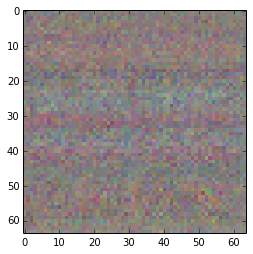

Step: 11
Discriminator loss: 
 1.3056
[torch.FloatTensor of size 1]

Generator loss: 
 0.7567
[torch.FloatTensor of size 1]



Process Process-162:
Process Process-161:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/Library/Python/2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
  File "/Library/Python/2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()


KeyboardInterrupt: 

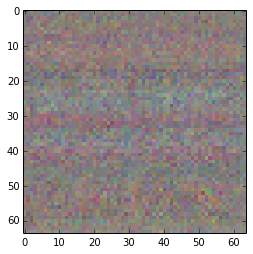

In [108]:
num_epochs = 100
for epoch in range(num_epochs):
    # 데이터 로더에서 데이터를 배치만큼 꺼내옵니다.
    for i, (data, _) in enumerate(dataloader):
        # Discriminator를 Update하는 loop입니다.
        discriminator.zero_grad()
        # Fake data는 Generator로부터 생성하고, real data도 받아옵니다.
        # .detach()는 generator weights들의 gradients를 계산하지 않기 위함입니다.
        fake_data = generator(Variable(torch.randn(16, 100))).detach()
        real_data = data
        
        # 각각의 점수를 계산합니다. (discriminator의 probabilities)
        fake_D = discriminator(fake_data)
        real_D = discriminator(Variable(real_data))
        
        # fake는 0, real은 1로 labeling 후 BCE loss를 계산합니다.
        negetive_loss = criterion(fake_D, Variable(torch.zeros(16)))
        positive_loss = criterion(real_D, Variable(torch.ones(16)))

        # 한 loop에서 gradient는 쌓이게 됩니다. 여기서는 .detach()함수로 인해 
        # Generator weights의 gradients는 계산되지 않았습니다.
        negetive_loss.backward()
        positive_loss.backward()
        
        # Discriminator weights들을 update 해줍니다.
        op_d.step()

        
        # Generator를 Update하는 loop입니다.
        generator.zero_grad()
        # 다시 한번 image를 generate합니다. 이번엔 generator weights의 gradient를 구할것입니다.
        gen_image = generator(Variable(torch.randn(16, 100)))
        fake_D_for_g = discriminator(gen_image)
        
        # 이 loss로 weights들의 gradients를 구합니다.
        gen_loss = criterion(fake_D_for_g, Variable(torch.ones(16)))
        gen_loss.backward()
        
        # Generator weights들만 update해줍니다.
        op_g.step()

        if i % 10 == 0:
            # Logging하여 결과를 봅니다.
            show(gen_image.data[0])
            print "Step: %d" %(i+1)
            print "Discriminator loss:", positive_loss.data + negetive_loss.data
            print "Generator loss:", gen_loss.data